# Anytown Database - Branch Res-vs-Diam
### First approx.

Change Working Directory

In [1]:
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir(r'C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB
Current working directory: C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB


#### Import

In [12]:
import wntr
import pandas as pd
import numpy as np
import networkx as nx

import plotly.graph_objects as go

#### Custom import of the Prasad & Park Index function

In [3]:
from PrasadParkIndex import *

#### Constants

In [4]:
M_TO_IN = 0.0254 #Meters into Inches
PMIN_ANYT = 28.1236 #m #Equivalent to 40 psi #REFERENCE

#### Upload the original inp file

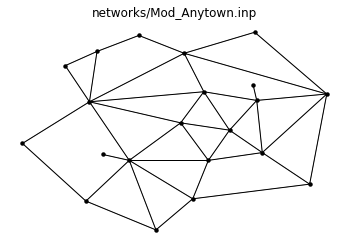

In [5]:
# Create a water network model
inp_file = 'networks/Mod_Anytown.inp'
wn_AnyT = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_AnyT, title=wn_AnyT.name)

# Simulate hydraulics
sim_AnyT = wntr.sim.EpanetSimulator(wn_AnyT)
results_AnyT = sim_AnyT.run_sim()

#### Preparation values for the database generation

In [6]:
num_pipes = wn_AnyT.num_pipes

#av_diams = [6, 8, 10, 12, 14, 16, 18, 20, 24, 30] #inches
avail_diams = [6, 8, 10, 12, 14] #inches
pipe_names = wn_AnyT.link_name_list

seed = 4345
np.random.seed(seed)

N_iter = 10

first_DB = []
fail_DB = []


### Loop for the DB generation
It overwrites the files if they have the same name

In [7]:
heading = 'Mod_AnyT'

for sim in range(N_iter):
    
    new_diams = [sim*2+6 for i in range(num_pipes)]#np.random.choice(avail_diams, num_pipes)
    new_diams = np.array(new_diams) * M_TO_IN
    
    for i in range(num_pipes):
        c_pipe = wn_AnyT.get_link(pipe_names[i])
        c_pipe.diameter = new_diams[i]
        #c_pipe.diameter =0 ## Test for the try
    try:
        # Simulate hydraulics
        sim_AnyT = wntr.sim.EpanetSimulator(wn_AnyT)
        results_AnyT = sim_AnyT.run_sim()
        DB_row = [sim]
        DB_row.append(np.round(new_diams/M_TO_IN, 0))
        DB_row.append(wn_AnyT)
        DB_row.append(sim_AnyT)
        DB_row.append(results_AnyT)
        try:
            flowrate = pd.DataFrame(results_AnyT.link['flowrate']['82']) #FLowrate at the link with the pump
        except Exception as e1:
            flowrate = 0
        
        RI_PP = PP_index(results_AnyT.node['head'], results_AnyT.node['pressure'], results_AnyT.node['demand'], flowrate, wn_AnyT, PMIN_ANYT)
        RI_Todini = wntr.metrics.hydraulic.todini_index(results_AnyT.node['head'], results_AnyT.node['pressure'], results_AnyT.node['demand'], flowrate, wn_AnyT, PMIN_ANYT)

        DB_row.append(RI_PP)
        DB_row.append(RI_Todini)
        
        DB_row.append(max(RI_PP))
        DB_row.append(max(RI_Todini))
        
        DB_row.append(min(RI_PP))
        DB_row.append(min(RI_Todini))
        
        DB_row.append(sum(RI_PP)/len(RI_PP))
        DB_row.append(sum(RI_Todini)/len(RI_PP))
        
        first_DB.append(DB_row)
        wn_AnyT.write_inpfile('Working files/' + heading+'_'+str(sim)+'.inp', version=2.2)
        
    except Exception as e:
        fail_row = [sim]
        fail_row.append(np.round(new_diams/M_TO_IN, 0))
        fail_row.append(wn_AnyT)
        fail_row.append(e)
        print(e)
        fail_DB.append(fail_row)
        wn_AnyT.write_inpfile('Failed files/' + 'fail_' + heading+'_'+str(sim)+ '.inp', version=2.2)

    #print('AnyT_'+str(sim)+'.inp')
    # Create INP
    

In [8]:
first_DB_pd = pd.DataFrame(first_DB, columns=['Sim_ID', 'Diams', 'wntrModel', 'EpanetSim', 'wntrResults', 'PrasadPark', 'Todini', 'maxPrPa', 'maxTod', 'minPrPa', 'minTod', 'avgPrPa', 'avgTod'])

In [9]:
first_DB_pd.shape

(10, 13)

<AxesSubplot:>

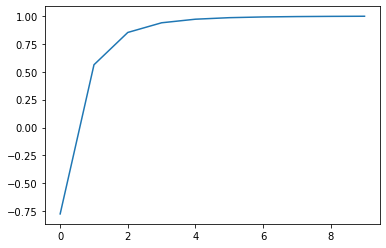

In [11]:
first_DB_pd['avgPrPa'].plot()

In [33]:
x_axis = [i*2+6 for i in range(N_iter)]
fig = go.FigureWidget(data=go.Scatter(x=x_axis, y=first_DB_pd['maxPrPa'],  line={'dash': 'dash'}, name = 'Max. Res'))

fig.add_trace(go.Scatter(x=x_axis, y=first_DB_pd['avgPrPa'],  line={'dash': 'dash'}, name='Avg. Res'))
fig.add_trace(go.Scatter(x=x_axis, y=first_DB_pd['minPrPa'],  line={'dash': 'dash'}, name='Min. Res.'))


fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Prasad & Park Resilience Index',
                    xaxis_title="Single Diameter (in)",
                    yaxis_title="Resilience",
                    legend_title="Legend",
                    autosize=False,
                    width=800,
                    height=500,)
#yaxis_zeroline=False, xaxis_zeroline=False)

fig

FigureWidget({
    'data': [{'line': {'dash': 'dash'},
              'marker': {'line': {'width': 2}, 'size': …

In [34]:
fig.write_html("Res_vs_SingleDiam.html")

##### Code that was replaced

In [ ]:
# Code snippets 
# new_diams=2*np.random.randint(3, 9, size=num_pipes)


### I'm inside the branch